In [2]:
import numpy as np
from common.ffn.ffn_tanh import TanhNet


In [3]:
def sample_covariance(neuron_one, trainpoint_one, neuron_two, trainpoint_two, yy):
    '''Sample covariance, formulas as in https://en.wikipedia.org/wiki/Sample_mean_and_covariance'''
    one = yy[:, neuron_one-1, trainpoint_one-1]
    two = yy[:, neuron_two-1, trainpoint_two-1]
    cov = np.cov(one, two)[0, 1]

    return cov


In [4]:
NN = 2000
'''n0: # dimension of x
    nk: # hidden nodes
    nl: # dimension of y
    l: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,l=NN,NN,NN,20
nd = NN
'''experiments_number: # number of experiments'''
experiments_number = 100

testNet = TanhNet(n0=n0,nk=nk,nl=nl,l=l)
testNet.set_log_level("info")
testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])

xx = np.random.normal(size=(n0, nd)).astype(np.float32)
yy = np.zeros((experiments_number, nl, nd))
#weights distribution variances are set as in (5.139)+(5.142): σ_1=tanh'(0)=1, c^0_w=1/σ_1^2, 
#c^1_w=2/(3*σ_1^2), n_l=10000
cb, cw = 0, (1.0 + (2.0/(NN*3.0)))

G01_records = []
G00_records = []
G11_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw)
    res = testNet.forward(xx)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    G11_records.append(testNet.get_gmetric(2,2).copy())
    G01_records.append(testNet.get_gmetric(1,2).copy())
    
    print('-', end='')


FeedForwardNet created with n0=2000, nk=2000, nl=2000, l=20, bias_on=False
----------------------------------------------------------------------------------------------------

In [5]:
nnd = 2
for trainpoint1 in range(1, nnd+1):
    for trainpoint2 in range(trainpoint1, nnd+1):
        print("Metric (4.8) for trainpoint {} and trainpoint {}: {}"\
              .format(trainpoint1, trainpoint2, TanhNet.G_xx(xx[:,trainpoint1-1], xx[:,trainpoint2-1], cb, cw)))

Metric (4.8) for trainpoint 1 and trainpoint 1: 1.0094997178548175
Metric (4.8) for trainpoint 1 and trainpoint 2: -0.023743524740219114
Metric (4.8) for trainpoint 2 and trainpoint 2: 1.021867791809082


In [6]:
nll, ndd = 2,2
for neuron1 in range(1, nll+1):
      for neuron2 in range(neuron1, nll+1):
            for trainpoint1 in range(1, ndd+1):
                  for trainpoint2 in range(1 if neuron1 != neuron2 else trainpoint1, ndd+1):
                        print("Sample covariance between neuron {}, trainpoint {} and neuron {}, trainpoint {}: {}"\
                              .format(neuron1, trainpoint1, neuron2, trainpoint2\
                                      , sample_covariance(neuron1,trainpoint1,neuron2,trainpoint2,yy)))

Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 1: 0.021487938500477803
Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 2: -0.0007841898562934422
Sample covariance between neuron 1, trainpoint 2 and neuron 1, trainpoint 2: 0.02117885443695245
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 1: -0.003909110487902079
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 2: 0.0002978475427266223
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 1: 0.0015574665130468424
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 2: -0.000405370949965032
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 1: 0.019212684815972637
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 2: -0.0010176920225796562
Sample covariance between neuron 2, trainpoint 2 and neuron 2, trainpoint 2: 0.026232519868881223


In [7]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'G01')

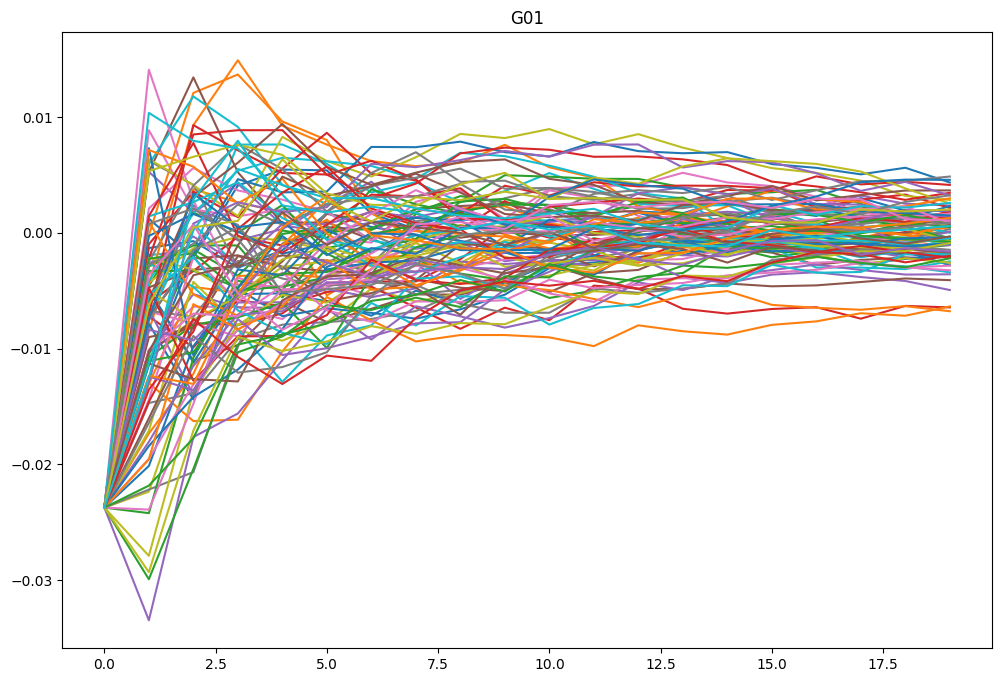

In [8]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G01_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G01")

In $G_{00}$ and $G_{11}$ there is an experimental dependency $G_{XX}^{(l)} = const / l^{1.3}$ approximately, i.e it's not exponential but polynomial decay.
This result approximately coincides with formula (5.94).

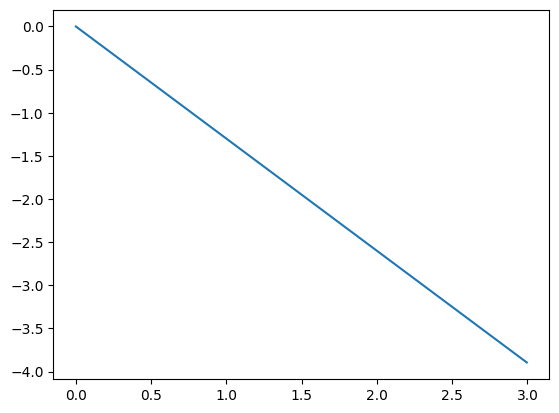

In [9]:
#Model graph for y=(1/x)**1.3
model_values = np.power((np.arange(20)+1), -1.3)
#zzzz = 1/np.exp((np.arange(20)+1))
plt.plot(np.log(np.arange(20)+1), np.log(model_values))


Text(0.5, 1.0, 'G00')

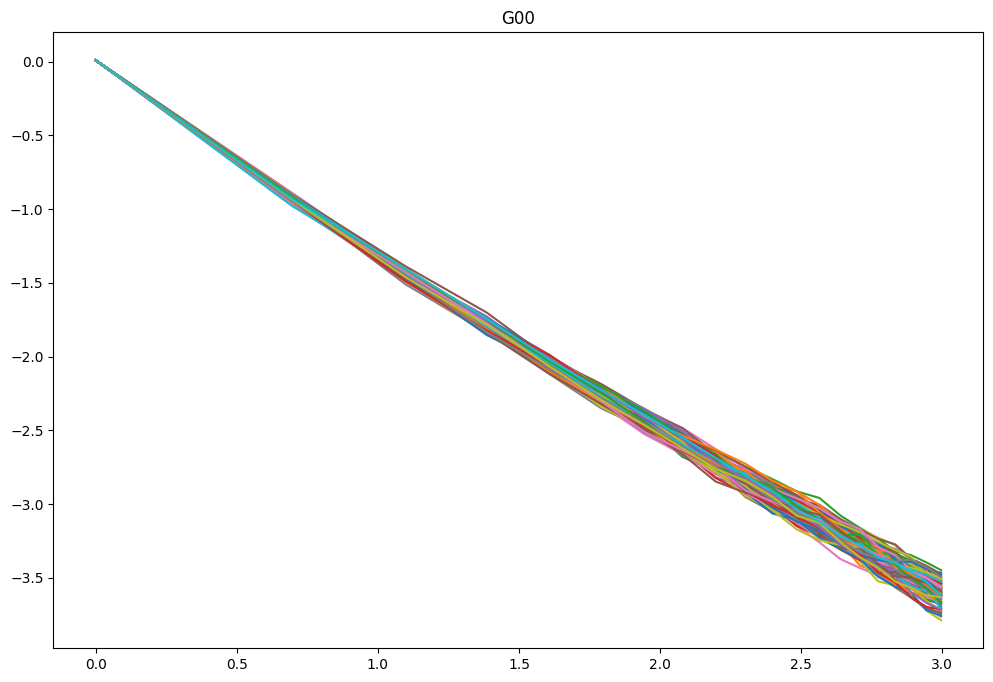

In [10]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G00_records):
    plt.plot(np.log(np.arange(20)+1), np.log(Gs), label=f"experiment {i}")
#plt.legend()
plt.title("G00")

Text(0.5, 1.0, 'G11')

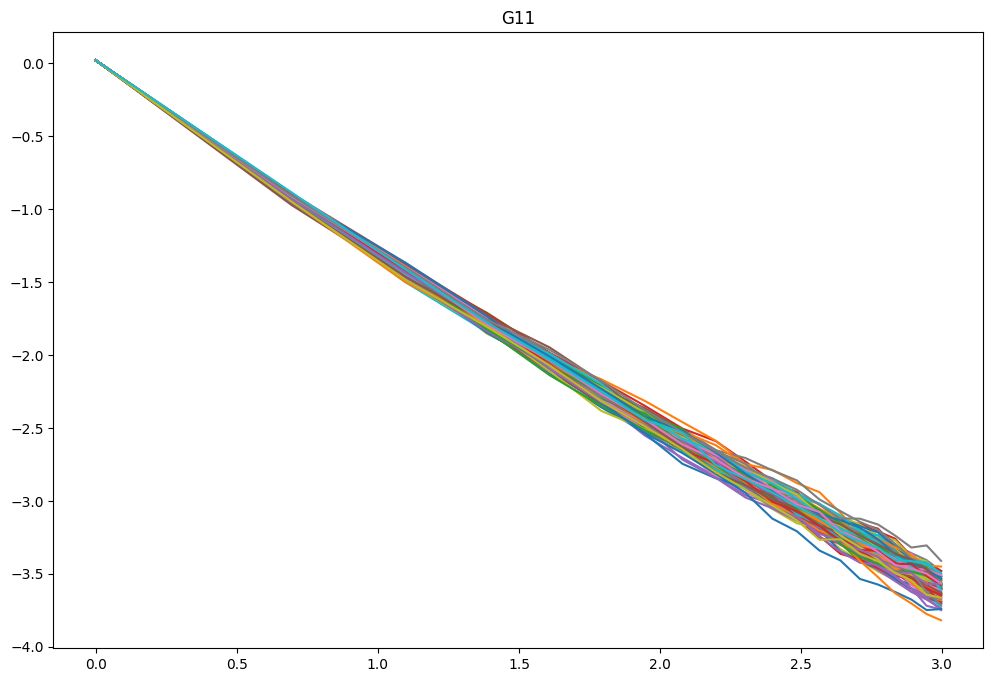

In [11]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G11_records):
    #plt.plot(np.log(Gs), label=f"experiment {i}")
    plt.plot(np.log(np.arange(20)+1), np.log(Gs), label=f"experiment {i}")
#plt.legend()
plt.title("G11")